##Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importing packages


In [ ]:
import glob, cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge
import keras.backend  as K


### Making Data in X_train and Y_train

In [ ]:
k = glob.glob('/content/drive/Shareddrives/mic_project/mini_data_0/*.jpg')
l = np.zeros((68,321,481))
iter = 0
print(k)
for i in k[:68]:
    image = cv2.imread(i)
    image = image[:, :, 0]
    d = image.shape
    b = 0
    if d[0] > d[1]:
        image = image.T
        b = 1
    l[iter,:,:] = image[:,:]
    transpose_array[iter] = b
    iter+=1


In [ ]:
k = glob.glob('/content/drive/Shareddrives/mic_project/mini_data/*.jpg')

lnew = np.zeros((500,321,481))
iter = 0
print(k)
for i in k[:500]:
    image = cv2.imread(i)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[:, :, 0]
    image = cv2.resize(image,(481,321))
    print(iter)
    lnew[iter,:,:] = image
    iter+=1


In [ ]:
k = glob.glob('/content/drive/Shareddrives/mic_project/mini_data_2/*.jpg')

lnewest = np.zeros((500,321,481))
l_noisenewest = np.zeros((500,321,481))
iter = 0
print(k)
for i in k[:500]:
    image = cv2.imread(i)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[:, :, 0]
    image = cv2.resize(image,(481,321))
    print(iter)
    lnewest[iter,:,:] = image

    l_noisenewest[iter,:,:] = image + np.random.normal(0, 25, (321, 481))
    iter+=1


In [ ]:
big = np.zeros((1068,321,481))

big[:68,:,:] = l
big[68:568,:,:] = lnew
big[568:,:,:] = lnewest
np.save('/content/drive/Shareddrives/mic_project/datanpy/lnew.npy', big)

In [ ]:

X_train = np.zeros((2272,321,481))
big = np.load('/content/drive/Shareddrives/mic_project/datanpy/lnew.npy')[:568,:,:]
t = big.shape[0]
X_train[:t,:,:] = big
X_train[t:2*t,:,:] = big
X_train[2*t:3*t,:,:] = big
X_train[3*t:4*t,:,:] = big

Y_train = np.zeros((2272,321,481))
t=t//2
iter = 0
for i in range(4):
  Y_train[iter*t:iter*t+t,:,:] = X_train[iter*t:iter*t+t,:,:] + np.random.normal(0,5*(iter+1),(321,481))
  Y_train[iter*t+t:iter*t+2*t,:,:] = X_train[iter*t+t:iter*t+2*t,:,:] + np.random.normal(0,5*(iter+2),(321,481))
  iter = iter+2

In [ ]:
np.save('/content/drive/Shareddrives/mic_project/datanpy/4k_orig.npy',X_train)
np.save('/content/drive/Shareddrives/mic_project/datanpy/4k_noisy.npy',Y_train)

In [ ]:

X = np.load('/content/drive/Shareddrives/mic_project/datanpy/4k_noisy.npy')
Y = np.load('/content/drive/Shareddrives/mic_project/datanpy/4k_orig.npy')

In [ ]:
print(X.shape)
print(Y.shape)

(2272, 321, 481)
(2272, 321, 481)


##Model Definition

In [ ]:
import tensorflow as tf
from keras.models import *
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Lambda,Subtract,concatenate,Add,merge
import keras.backend  as K
def denoiser():
    inpt = Input(shape=(None,None,1))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    x = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(x)
    x = Activation('relu')(x)
    # 15 layers, Conv+BN+relu
    for i in range(7):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)   
    # last layer, Conv 
    for i in range(8):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x) 
    x = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([inpt, x])   # input - noise

    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(inpt)
    y = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(y)
    y = Activation('relu')(y)
    # 15 layers, Conv+BN+relu
    for i in range(7):
        y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
        y = Activation('relu')(y)   
    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    y = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(y)
    y = Activation('relu')(y) 
    for i in range(6):
        y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),dilation_rate=(2,2), padding='same')(y)
        y = Activation('relu')(y)
    y = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    y = tf.keras.layers.BatchNormalization(axis=-1, epsilon=1e-3)(y)
    y = Activation('relu')(y)    
    y = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    y = Subtract()([inpt, y])   # input - noise

    o = concatenate([x,y],axis=-1)
    z = Conv2D(filters=1, kernel_size=(3,3), strides=(1,1), padding='same')(o)
    z = Subtract()([inpt, z])
    model = Model(inputs=inpt, outputs=z)
    return model

In [ ]:
model = denoiser()

##Data Loading

In [ ]:
X = np.load('/content/drive/Shareddrives/mic_project/736_project/datanpy/4k_noisy.npy')
Y = np.load('/content/drive/Shareddrives/mic_project/736_project/datanpy/4k_noisy.npy')

##Data visualization

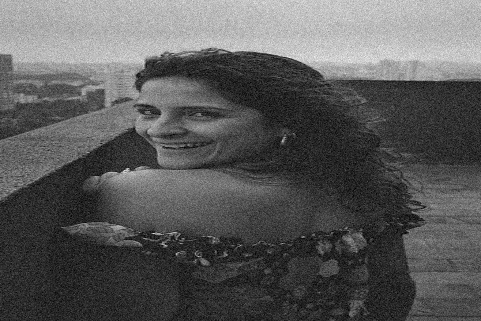

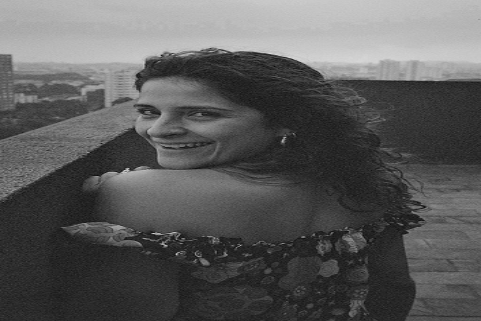

In [ ]:
noisy = X[500,:,:]
noiseless = Y[500,:,:]
cv2_imshow(noisy)
cv2_imshow(noiseless)

In [ ]:
print(X_train.shape)
Y_train = np.zeros()

(568, 321, 481)
(568, 321, 481)


##Training

In [ ]:
import keras
model.load_weights('/content/drive/Shareddrives/mic_project/736_project/Model/4k_model.h5')

In [ ]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, None, None, 6 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, None, None, 6 256         conv2d_35[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, None, None, 6 0           batch_normalization_19[0][0]     
____________________________________________________________________________________________

### Actual Training

In [ ]:
#### TRAINING

from keras.optimizers import Adam
model.compile(optimizer= Adam(),loss=['mse'])
model.fit(x=np.reshape(X,(2272,321,481,1)),y=np.reshape(Y,(2272,321,481,1)),
          batch_size=2,
          epochs=2,
          verbose=1)

model.save_weights('/content/drive/Shareddrives/mic_project/736_project/Model/4k_model.h5')

Epoch 1/2
1136/1136 [==============================] - 973s 825ms/step - loss: 190.7040
Epoch 2/2
1136/1136 [==============================] - 943s 830ms/step - loss: 62.4735


### Loading Weights

In [ ]:
import keras
model = denoiser()
model.load_weights('/content/drive/Shareddrives/mic_project/736_project/Model/4k_model.h5')

##Testing

In [ ]:
model.load_weights('/content/drive/Shareddrives/mic_project/736_project/Model/4k_model.h5')

24.596334 denoised  : 398.33216178473873 noisy
variance 20


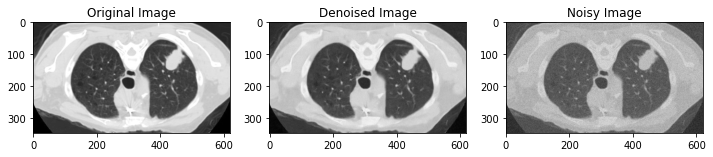

34.904827 denoised  : 400.7273575261892 noisy
variance 20


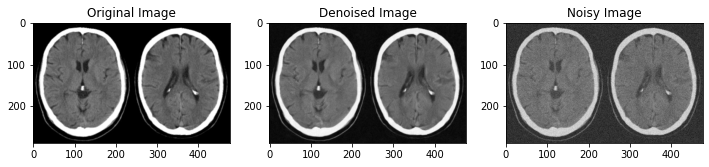

18.014471 denoised  : 398.73693258296544 noisy
variance 20


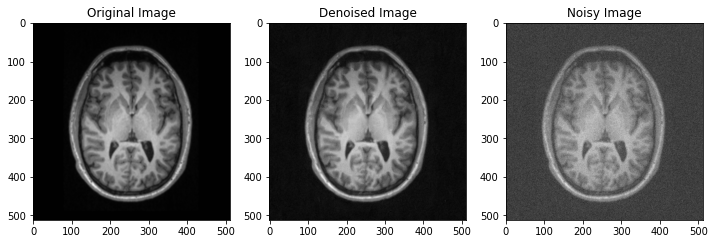

36.014397 denoised  : 903.5752055335032 noisy
variance 30


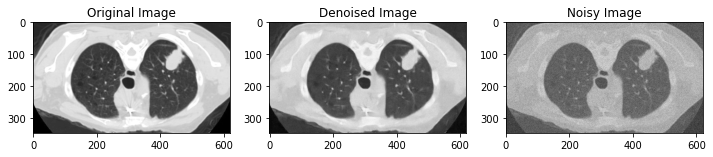

47.82348 denoised  : 898.6080261040879 noisy
variance 30


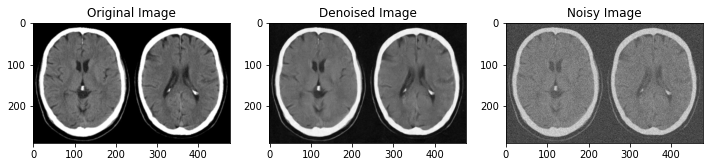

25.840868 denoised  : 896.414847251578 noisy
variance 30


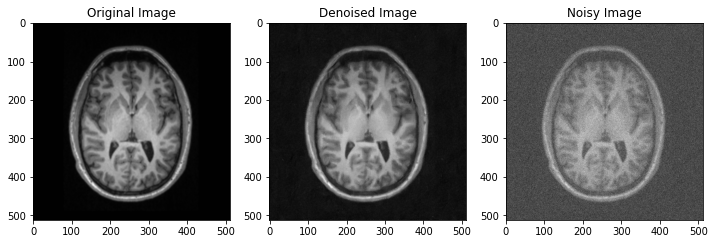

138.84567 denoised  : 1597.4367603814317 noisy
variance 40


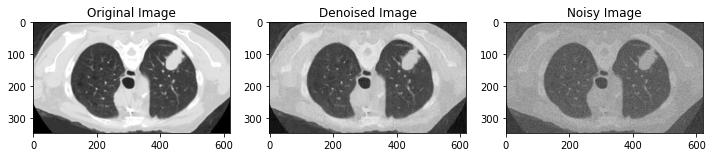

140.5115 denoised  : 1612.1266673928283 noisy
variance 40


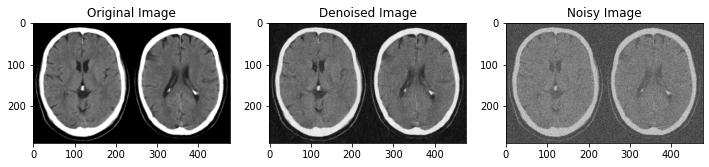

113.29971 denoised  : 1600.759744320503 noisy
variance 40


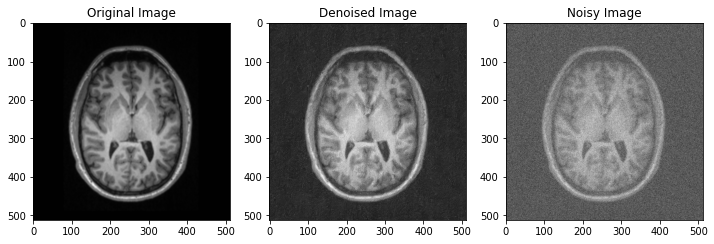

In [ ]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
K = glob.glob('/content/drive/Shareddrives/mic_project/736_project/Testing_data/*.png')
var = [20, 30, 40]
for v in var:
  iter = 1
  for i in K[12:]:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t = (1,img.shape[0],img.shape[1],1)
    img_n = img+np.random.normal(0, v, (t[1],t[2]))
    out = model.predict(np.reshape(img_n, t))
    out = np.reshape(out,(t[1],t[2]))

    mse_d = np.square(np.subtract(img, out)).mean()
    mse_n = np.square(np.subtract(img, img_n)).mean()
    print(mse_d, 'denoised  :', mse_n, 'noisy')
    print('variance', v)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img/255,cmap=cm.gray)
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(out, cmap=cm.gray)
    plt.title('Denoised Image')
    plt.subplot(1,3,3)
    plt.imshow(img_n, cmap=cm.gray)  
    plt.title('Noisy Image')
    plt.show()
    iter = iter + 1


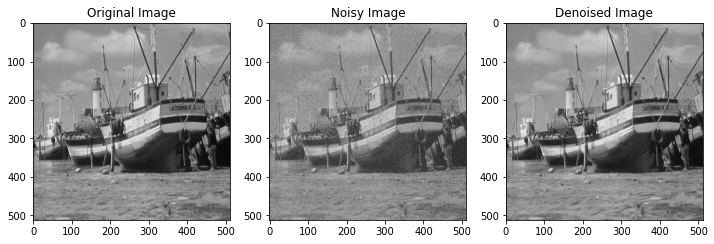

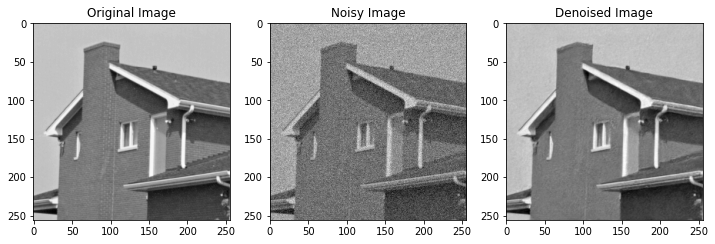

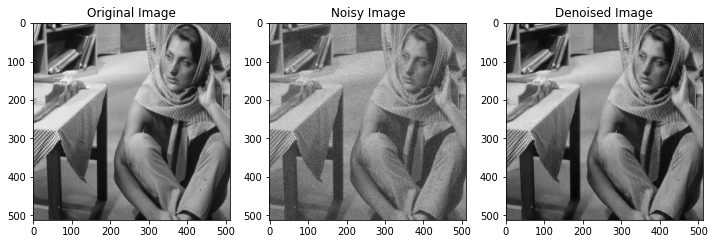

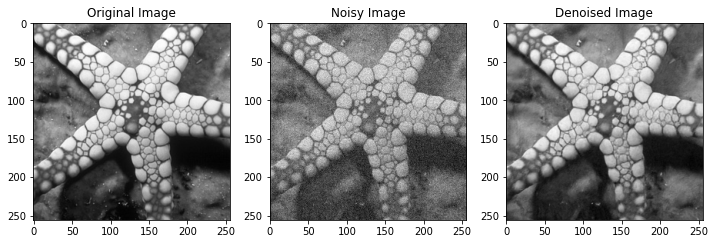

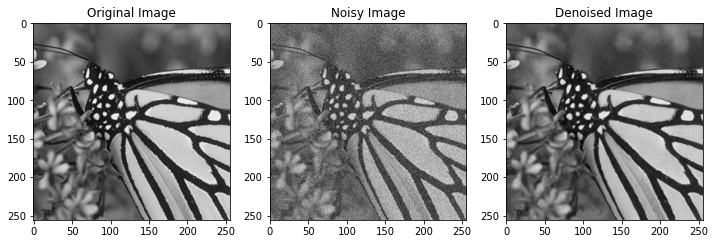

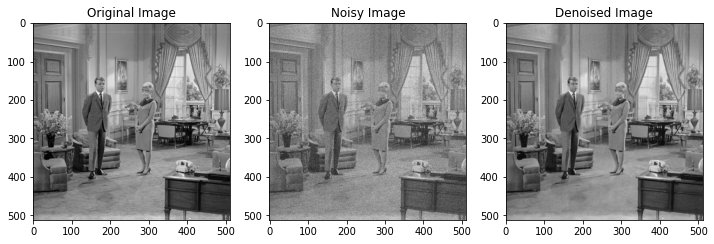

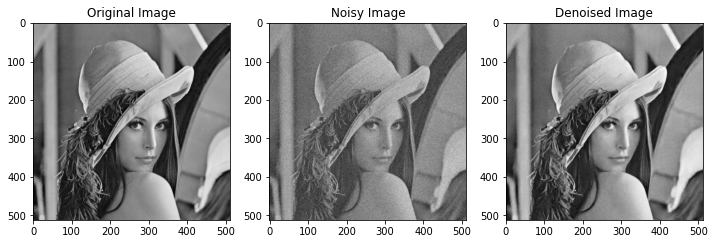

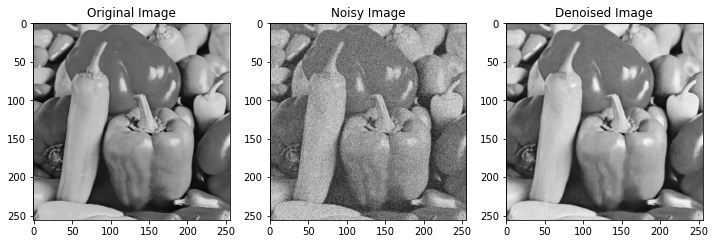

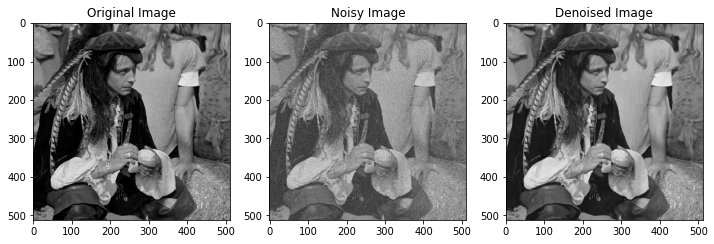

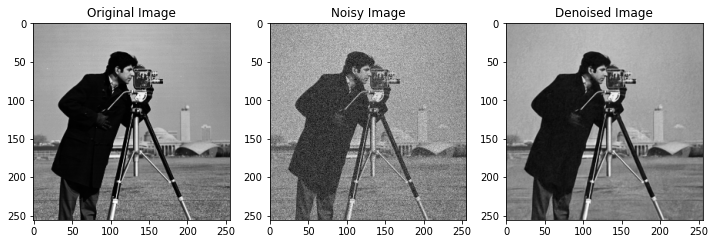

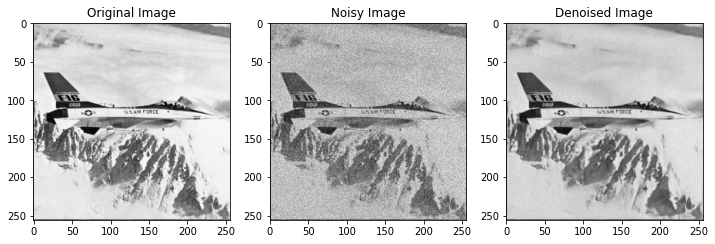

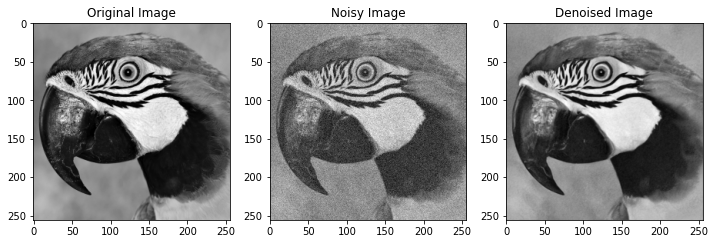

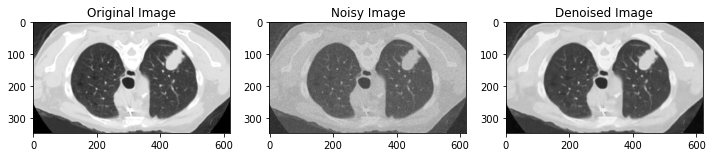

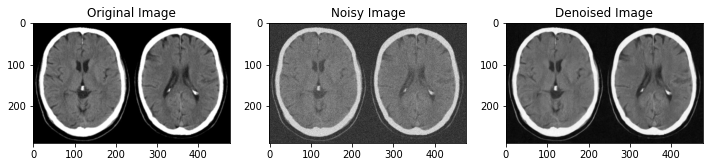

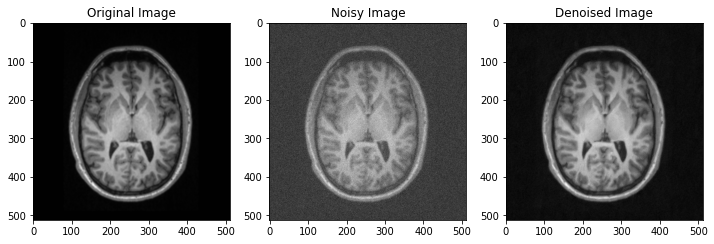

In [ ]:
K = glob.glob('/content/drive/Shareddrives/mic_project/736_project/Testing_data/*.png')
for i in K:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  t = (1,img.shape[0],img.shape[1],1)
  
  img_n = img + np.random.normal(0, 20, (t[1],t[2]))
  out = model.predict(np.reshape(img_n, t))

  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(img/255, cmap=cm.gray)
  plt.title('Original Image')
  out = np.reshape(out, (t[1],t[2]))
  plt.subplot(1,3,2)
  plt.imshow(img_n, cmap=cm.gray)
  plt.title('Noisy Image')
  plt.subplot(1,3,3)
#   cv2_imshow(out)
  plt.imshow(out, cmap=cm.gray)
  plt.title('Denoised Image')
  plt.show()

#Y_train[1,:,:].shape

##MSE For comparing with traditional

In [ ]:
model.load_weights('/content/drive/Shareddrives/mic_project/Model/model_2_30.h5')

NameError: ignored

In [ ]:
K = glob.glob('/content/drive/Shareddrives/mic_project/BRDNet12/grayimage/data/Test/Set12/*.png')
for i in K[2:3]:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  t = (1,img.shape[0],img.shape[1],1)
  
  img_n = img + np.random.normal(0, 20, (t[1],t[2]))
  out = model.predict(np.reshape(img_n, t))

  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1)
  plt.imshow(img/255, cmap=cm.gray)
  plt.title('Original Image')
  out = np.reshape(out, (t[1],t[2]))
  plt.subplot(1,3,2)
  plt.imshow(img_n, cmap=cm.gray)
  plt.title('Noisy Image')
  plt.subplot(1,3,3)
#   cv2_imshow(out)
  plt.imshow(out, cmap=cm.gray)
  plt.title('Denoised Image')
  plt.show()

#Y_train[1,:,:].shape

NameError: ignored

In [ ]:
diff = out-img
k = np.square(diff)
q = (np.sum(k)/(512*512))
print(q)
print('rmse- ' + str(np.sqrt(q)))

56.49932861328125
rmse- 7.51660352907357
